# Modelo de Classificação de Pneumonia através de raios X

## Introdução:
* Com a recente pandemia provocada pelo surto de COVID-19, foi necessário um esforço do sistema de saúde de cada país em diagnosticas e tratar os sintomas da doença em um grande número de pacientes ao dia. O estresse provocado no sistema de saúde devido ao grande número de pacientes e consequentemente diagnósticos, podem reduzir a qualidade desses diagnósticos, uma vez que os responsáveis (médicos) estão sobre alta demanda e pressão.
* Uma das doenças causas pela covid-19 é a Pneumonia, que pode ser vista em exames de Raio-X e se diagnosticada com precisão e antecedência, será vital para o tratamento do paciente.

## Objetivo:
* O objetivo desse notebook é criar um modelo de Deep Learning, que possa diagnosticar Pneumonia através de exames de Raio-X.
* A meta é alcançar uma acurácia do modelo, superior a 90% com maior redução possível dos falsos negativos, uma vez que se tratando da saúde humana, devemos nos atentar aqueles diagnósticos preditos como Normais, mas que na realidade são positivos para Pneumonia. Pois, ao diagnosticar o paciente como normal, sendo esse positivo, as chances de tratamento correto diminuem, podendo por em risco a vida do paciente.

## Dataset:
* O dataset contendo as imagens de Raio-X normais e com pneumonia, foram encontrados em: https://data.mendeley.com/datasets/rscbjbr9sj/2

## Conteúdo:
* Os dados contém imagens de raio-x, classificados previamente dentro de suas respectivas pastas, como normal ou pneumonia.

### Importando bibliotecas necessárias

In [43]:
import os
import random
import re
import pathlib
from glob import glob
import datetime

from matplotlib import image
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, plot_roc_curve, auc

%matplotlib inline

#### Armazenando os paths de cada imagem em uma variável chamada images_dir

In [2]:
images_dir = glob(os.path.join('./chest_xray/*/*/', '*.jpeg'))
len(images_dir)

5856

### Nesta etapa será criado uma lista, que conterá as imagens já transformadas para RGB (caso não estejam) de tipo pillow, que facilitará a manipulação e visualização das imagens

In [3]:
imgs_chest=[]
for i in range(len(images_dir)):
    imgs_chest.append(PIL.Image.open(str(images_dir[i])).convert('RGB'))

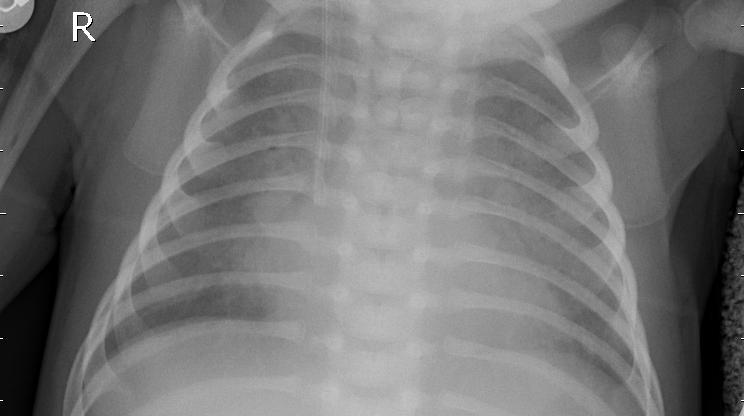

In [4]:
imgs_chest[234]

#### Transformando as imagens para dimensões 205x205 e através do filtro EDGE_ENHANCE estamos aplicando uma definição maior paras as bordas.
* O objetivo do filto é facilitar a rede neural adiante, tanto a artificial quanto a convolucional.

In [5]:
for i in range(len(imgs_chest)):
    imgs_chest[i] = (imgs_chest[i].resize((205, 205))).filter(PIL.ImageFilter.EDGE_ENHANCE)

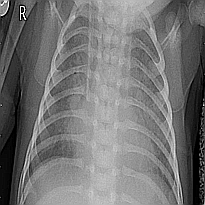

In [6]:
imgs_chest[234]

#### Criando um dataset que irá conter o path das imagens, o tipo de doença, o nome da imagem e as labels já em inteiros para futura avaliação e criação da rede.

In [7]:
df = pd.DataFrame(images_dir, columns=['image_path'])
df.head()

,image_path
0,./chest_xray/test/PNEUMONIA/person147_bacteria...
1,./chest_xray/test/PNEUMONIA/person100_bacteria...
2,./chest_xray/test/PNEUMONIA/person78_bacteria_...
3,./chest_xray/test/PNEUMONIA/person124_bacteria...
4,./chest_xray/test/PNEUMONIA/person1647_virus_2...


In [8]:
disease = []
for i in range(len(images_dir)):
    regex_obj = re.search(r"/[\w]{6,9}/", images_dir[i])
    disease.append(regex_obj[0])
disease = [bar.replace('/', '') for bar in disease]

In [9]:
df['disease'] = pd.DataFrame(disease)

In [10]:
filename = []
for i in range(len(images_dir)):
    regex_obj = re.search(r"[-\w.]*jpeg", images_dir[i])
    filename.append(regex_obj[0])
df['filename'] = pd.DataFrame(filename)

In [11]:
df[120:410].head()

,image_path,disease,filename
120,./chest_xray/test/PNEUMONIA/person1678_virus_2...,PNEUMONIA,person1678_virus_2895.jpeg
121,./chest_xray/test/PNEUMONIA/person20_virus_51....,PNEUMONIA,person20_virus_51.jpeg
122,./chest_xray/test/PNEUMONIA/person1631_virus_2...,PNEUMONIA,person1631_virus_2826.jpeg
123,./chest_xray/test/PNEUMONIA/person87_bacteria_...,PNEUMONIA,person87_bacteria_434.jpeg
124,./chest_xray/test/PNEUMONIA/person101_bacteria...,PNEUMONIA,person101_bacteria_485.jpeg


#### Dataset final

In [12]:
categorical_labels = (df['disease'].unique()).tolist()
numeric_labels = list(range(len(categorical_labels)))

df['labels'] = df['disease'].replace(categorical_labels, numeric_labels)
df.head()

,image_path,disease,filename,labels
0,./chest_xray/test/PNEUMONIA/person147_bacteria...,PNEUMONIA,person147_bacteria_706.jpeg,0
1,./chest_xray/test/PNEUMONIA/person100_bacteria...,PNEUMONIA,person100_bacteria_482.jpeg,0
2,./chest_xray/test/PNEUMONIA/person78_bacteria_...,PNEUMONIA,person78_bacteria_382.jpeg,0
3,./chest_xray/test/PNEUMONIA/person124_bacteria...,PNEUMONIA,person124_bacteria_589.jpeg,0
4,./chest_xray/test/PNEUMONIA/person1647_virus_2...,PNEUMONIA,person1647_virus_2848.jpeg,0


#### Transformando as imagens em tensores e separando-as em features e labels

In [14]:
X = []
for i in range(len(imgs_chest)):
    X.append(np.array(imgs_chest[i]))

X = np.array(X)
X.shape, type(X[0])

((5856, 205, 205, 3), numpy.ndarray)

In [15]:
y = df['labels'].to_numpy()

In [16]:
y.shape

(5856,)

#### Visualizando algumas imagens

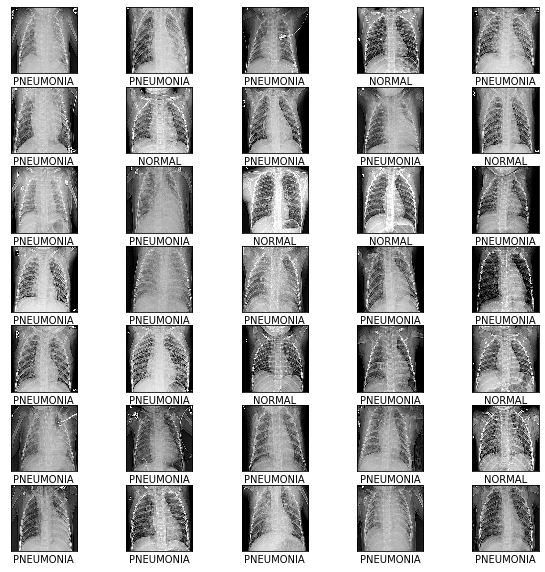

In [17]:
plt.figure(figsize=(10, 10))
j=0
for i in random.sample(range(0, len(images_dir)), 35):
    plt.subplot(7, 5, j+1)
    plt.imshow(imgs_chest[i], cmap=plt.cm.inferno)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(df.values[i][1], color="k")
    j = j +1
plt.show();

#### Foi identificado um problema não balanceado

In [18]:
df['disease'].value_counts()

PNEUMONIA    4273
NORMAL       1583
Name: disease, dtype: int64

In [19]:
df['disease'].value_counts()[0]/df['disease'].value_counts()[1]

2.6993051168667086

> Foi identificado que a quantidade de imagens classificadas como pneumonia são 2.69x maior que a quantidade de imagens classificadas como normais.

#### Separando os dados em treino e teste

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

##### Verificando a quantidade de classes nos dados de teste
* O objetivo desse passo é definir um peso maior as imagens normais, para tentar balancear o problema, dando maior importancia para essas imagens, de forma a equilibrar os dados.

In [21]:
unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([0, 1]), array([2868, 1055]))

In [22]:
weight_class1 = counts[0]/counts[1]
weight_class1

2.718483412322275

> O peso para classe 1 (normal) foi definido como 2.71.

### Construindo modelo de Rede Neural Artificial

In [23]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=(205, 205, 3)),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')                      
])
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model.compile(loss=tf.keras.metrics.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 126075)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16137728  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 16,137,857
Trainable params: 16,137,857
Non-trainable params: 0
_________________________________________________________________


> Como observado, foi criado um modelo de rede neural artificial simples, com saída através de uma função de ativação sigmoid, já que temos um problema de classificação binário, assim como no compile é definido a loss como binária.
> Também foi adicionado uma função do Keras chamada ReduceLROnPlateau, que tem como objetivo reduzir a taxa de aprendizado quando a acurácia dos dados de validação atinge um platô.
* No fit a seguir, separamos o conjunto de treino também em um conjunto de validação, para que tenhamos já uma avaliação da validação através de um histórico gerado pelo fit.

In [24]:
history = model.fit(X_train,
                    y_train,
                    batch_size = 32,
                    epochs = 20,
                    validation_split=0.2,
                    verbose = 1,
                    class_weight={0:1, 1:weight_class1},
                    callbacks=[learning_rate_reduction])

Train on 3138 samples, validate on 785 samples
Epoch 1/20
3138/3138 [==============================] - 12s 4ms/sample - loss: 1762.7572 - accuracy: 0.6989 - precision: 0.4550 - recall: 0.7138 - val_loss: 67.7971 - val_accuracy: 0.3631 - val_precision: 0.3122 - val_recall: 1.0000
Epoch 2/20
3138/3138 [==============================] - 11s 3ms/sample - loss: 9.2435 - accuracy: 0.8681 - precision: 0.6998 - recall: 0.8756 - val_loss: 13.1781 - val_accuracy: 0.8866 - val_precision: 0.9792 - val_recall: 0.6211
Epoch 3/20
3138/3138 [==============================] - 11s 3ms/sample - loss: 6.9525 - accuracy: 0.8881 - precision: 0.7421 - recall: 0.8829 - val_loss: 3.1281 - val_accuracy: 0.8854 - val_precision: 0.7338 - val_recall: 0.9471
Epoch 4/20
3138/3138 [==============================] - 11s 4ms/sample - loss: 3.9256 - accuracy: 0.8869 - precision: 0.7377 - recall: 0.8865 - val_loss: 7.6637 - val_accuracy: 0.8879 - val_precision: 0.9664 - val_recall: 0.6344
Epoch 5/20
3138/3138 [==========

#### Plotando a evolução do modelo ao longo das 20 épocas, sendo validação e treino.

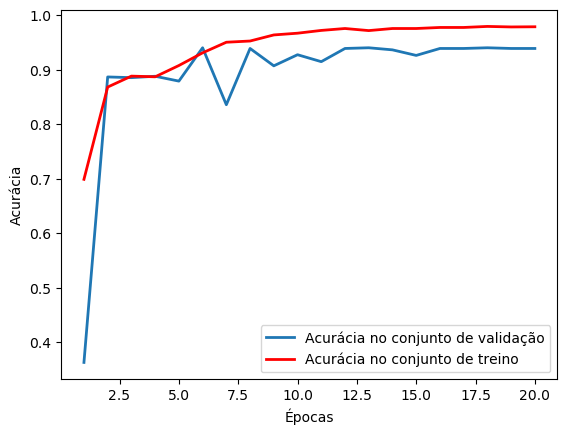

In [25]:
history_dict = history.history
accuracy = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
range_epochs = range(1, len(accuracy) + 1)

plt.style.use('default')
accuracy_val = plt.plot(range_epochs, val_acc, label='Acurácia no conjunto de validação')
accuracy_train = plt.plot(range_epochs, accuracy, label='Acurácia no conjunto de treino', color="r")
plt.setp(accuracy_val, linewidth=2.0)
plt.setp(accuracy_train, linewidth=2.0)
plt.xlabel('Épocas') 
plt.ylabel('Acurácia')
plt.legend(loc="lower right")
plt.show()

#### Armazenando os predicts do modelo em uma variável val_predicts e transformando cada elemento em 0 e 1 através de um loop for.

In [26]:
val_predicts = model.predict(X_test)
y_pred = [1 * (x[0]>=0.5) for x in val_predicts]

#### Avaliando o modelo no conjunto de teste

In [27]:
model.evaluate(X_test,y_test)

1933/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.22176293997152816, 0.93636835, 0.90744466, 0.8541667]

> Foi atingido uma boa acurácia, porem observamos uma queda no recall, que tentamos aumentar ao máximo, evitando falsos negativos.

#### Avaliando os predicts através de uma matriz de confusão.

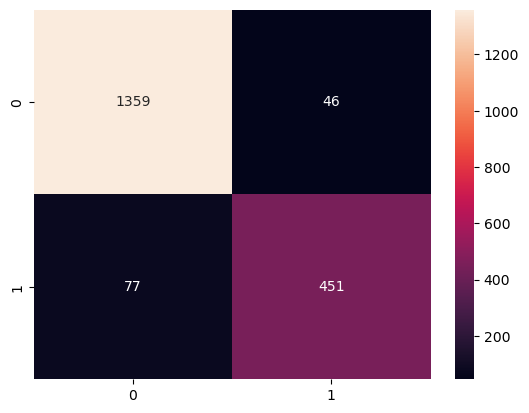

In [28]:
cm = confusion_matrix(y_test, y_pred)
sn = sns.heatmap(cm, annot=True, fmt="");

#### Criando uma função que plota a ROC Curve e o AUC score, para avaliação do modelo binário.

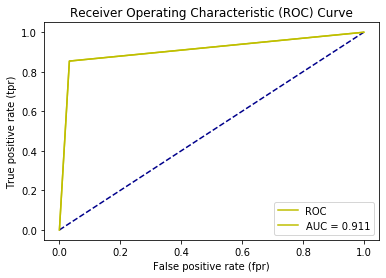

In [54]:
def plot_roc(y_test, y_pred):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)

    # Plot roc curve
    plt.plot(fpr, tpr, color="y", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr,tpr)), color='y')
    
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()

plot_roc(y_test, y_pred)

> Tivemos bons resultados, apesar dos valor de recall estar mais baixo, resultando em 77 falsos negativos.

### Criando modelo de Rede Neural Convolucional

In [30]:
model_cnn = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(205, 205,3)),
                             tf.keras.layers.Conv2D(64, (5,5), activation='relu', padding='same'),
                             tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')                      
])

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

model_cnn.compile(loss=tf.keras.metrics.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

print(model_cnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 205, 205, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 205, 205, 64)      51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 102, 102, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 102, 102, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 665856)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               85229696  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

> Foram criadas duas camadas de filtragem, a primeira com 32 filtros em uma matriz 5x5 e outra posterior com 64 de mesmas dimensões, posteriormente foi aplicado o maxpooling afim de reduzir essas dimensoes.

### Repetindo o workflow do modelo anterior

In [32]:
history2 = model_cnn.fit(X_train,
                        y_train,
                        batch_size = 32,
                        epochs = 10,
                        validation_split=0.2,
                        verbose = 1,
                        class_weight={0:1, 1:weight_class1},
                        callbacks=[learning_rate_reduction])

Train on 3138 samples, validate on 785 samples
Epoch 1/10
3138/3138 [==============================] - 438s 139ms/sample - loss: 6.0987 - accuracy: 0.7677 - precision: 0.5431 - recall: 0.7536 - val_loss: 0.6604 - val_accuracy: 0.8548 - val_precision: 0.7132 - val_recall: 0.8326
Epoch 2/10
3138/3138 [==============================] - 415s 132ms/sample - loss: 0.5666 - accuracy: 0.8722 - precision: 0.7091 - recall: 0.8744 - val_loss: 0.6045 - val_accuracy: 0.8497 - val_precision: 0.6823 - val_recall: 0.8987
Epoch 3/10
3138/3138 [==============================] - 387s 123ms/sample - loss: 0.3931 - accuracy: 0.9101 - precision: 0.7862 - recall: 0.9058 - val_loss: 0.5792 - val_accuracy: 0.8573 - val_precision: 0.7032 - val_recall: 0.8767
Epoch 4/10
3138/3138 [==============================] - 389s 124ms/sample - loss: 0.3180 - accuracy: 0.9299 - precision: 0.8312 - recall: 0.9215 - val_loss: 0.6100 - val_accuracy: 0.8611 - val_precision: 0.7323 - val_recall: 0.8194
Epoch 5/10
3138/3138 [===

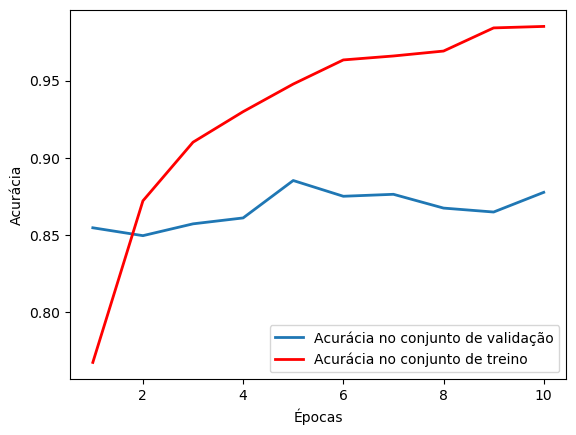

In [33]:
history_dict2 = history2.history
accuracy = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
range_epochs = range(1, len(accuracy) + 1)

plt.style.use('default')
accuracy_val = plt.plot(range_epochs, val_acc, label='Acurácia no conjunto de validação')
accuracy_train = plt.plot(range_epochs, accuracy, label='Acurácia no conjunto de treino', color="r")
plt.setp(accuracy_val, linewidth=2.0)
plt.setp(accuracy_train, linewidth=2.0)
plt.xlabel('Épocas') 
plt.ylabel('Acurácia')
plt.legend(loc="lower right")
plt.show()

In [34]:
model_cnn.evaluate(X_test,y_test)

1933/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.7788401090044218, 0.87739265, 0.77196264, 0.782197]

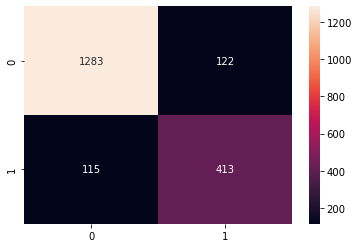

In [51]:
probs_cnn = model_cnn.predict(X_test.astype('float'))
y_pred2 = [1 * (x[0]>=0.5) for x in probs_cnn]
cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, annot=True, fmt="");


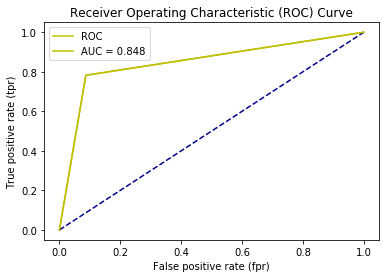

In [55]:
plot_roc(y_test, y_pred2)

##### Observado uma queda de desempenho considerável entre os modelos, com redução da acurácia e aumento de falsos negativos e positivos. Consequentemente, diminuição da area under the curve.

### Criando novo modelo convolucional.
* Dessa vez será aplicado apenas um filtro de convolução, pois inicialmente fizemos um tratamento nas bordas de cada imagem, dessa forma, podemos otimizar o tempo e ter um resultado melhor com apenas uma convolução, diferente do modelo anterior.

In [36]:
model_cnn2 = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(205, 205,3)),
                             tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')])
                            
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

model_cnn2.compile(loss=tf.keras.metrics.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

print(model_cnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 205, 205, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 205, 205, 64)      51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 102, 102, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 102, 102, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 665856)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               85229696  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [37]:
history3 = model_cnn2.fit(X_train,
                            y_train,
                            batch_size = 32,
                            epochs = 10,
                            validation_split=0.2,
                            verbose = 1,
                            class_weight={0:1, 1:weight_class1},
                            callbacks=[learning_rate_reduction])

Train on 3138 samples, validate on 785 samples
Epoch 1/10
3138/3138 [==============================] - 67s 21ms/sample - loss: 400.0953 - accuracy: 0.8174 - precision: 0.6211 - recall: 0.7899 - val_loss: 3.7622 - val_accuracy: 0.8828 - val_precision: 0.7647 - val_recall: 0.8590
Epoch 2/10
3138/3138 [==============================] - 64s 21ms/sample - loss: 1.1454 - accuracy: 0.9178 - precision: 0.8032 - recall: 0.9118 - val_loss: 1.3697 - val_accuracy: 0.9274 - val_precision: 0.8571 - val_recall: 0.8987
Epoch 3/10
3138/3138 [==============================] - 64s 20ms/sample - loss: 0.3116 - accuracy: 0.9576 - precision: 0.8962 - recall: 0.9493 - val_loss: 1.0716 - val_accuracy: 0.9108 - val_precision: 0.8230 - val_recall: 0.8811
Epoch 4/10
3138/3138 [==============================] - 61s 20ms/sample - loss: 0.3110 - accuracy: 0.9583 - precision: 0.8938 - recall: 0.9553 - val_loss: 1.0950 - val_accuracy: 0.9248 - val_precision: 0.8621 - val_recall: 0.8811
Epoch 5/10
3136/3138 [=========

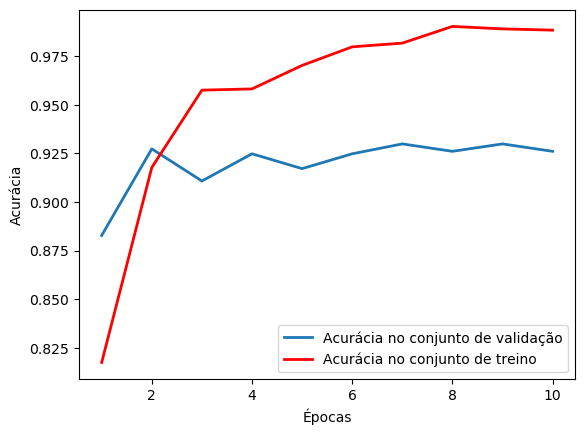

In [38]:
history_dict3 = history3.history
accuracy = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
range_epochs = range(1, len(accuracy) + 1)

plt.style.use('default')
accuracy_val = plt.plot(range_epochs, val_acc, label='Acurácia no conjunto de validação')
accuracy_train = plt.plot(range_epochs, accuracy, label='Acurácia no conjunto de treino', color="r")
plt.setp(accuracy_val, linewidth=2.0)
plt.setp(accuracy_train, linewidth=2.0)
plt.xlabel('Épocas') 
plt.ylabel('Acurácia')
plt.legend(loc="lower right")
plt.show()

In [39]:
model_cnn2.evaluate(X_test,y_test)

1933/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3490936447087188, 0.93792033, 0.8763838, 0.8996212]

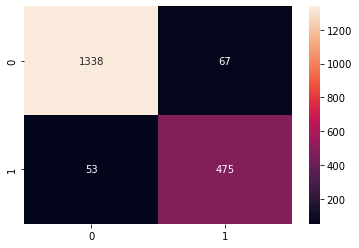

In [49]:
probs_cnn2 = model_cnn2.predict(X_test.astype('float'))
y_pred3 = [1 * (x[0]>=0.5) for x in probs_cnn2]

cm3 = confusion_matrix(y_test, y_pred3)
sn = sns.heatmap(cm3, annot=True, fmt="");

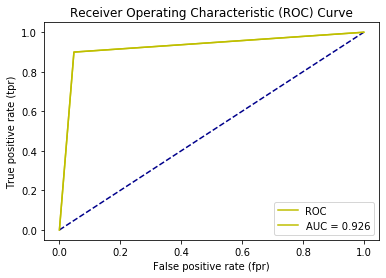

In [57]:
plot_roc(y_test, y_pred3)

## Conclusão:
* Com o segundo modelo de convolução (model_cnn2) atingimos uma maior acurácia e reduzimos o recall, por isso, também houve o aumento da AUC score.
* Iremos salvar os modelos de convolução 2 (model_cnn2) e o de rede neural artificial, para posteriores estudos!

### Salvando modelos    

In [58]:
def save_model(model, suffix=None):

  modeldir = os.path.join("./models/",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5"
  print(f"Salvando modelo em: {model_path}...")
  model.save(model_path)
  return model_path

save_model(model, suffix="rna_model")
save_model(model_cnn2, suffix="improved_cnn_model")

Salvando modelo em: ./models/20220725-12061658761590-rna_model.h5...
Salvando modelo em: ./models/20220725-12061658761591-improved_cnn_model.h5...


'./models/20220725-12061658761591-improved_cnn_model.h5'